In [1]:
pip install foolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
import foolbox as fb
import torch.optim as optim


trainMode = True
constrain = True
randd = random.randint(0,1000)
#randd = 528
print(f"Current random number : {randd}")
from google.colab import drive
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/Cifar100Experiments/ContractiveNetwork_10"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
from utils import *
from NormalizedConvolutions import *
from networkTraining import *
from multiClassHinge import *
from LipschitzConstant import *
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

Current random number : 836
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Cifar100Experiments/ContractiveNetwork_10
cuda:0


In [3]:
# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
a = 0.1
M = 1

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Normalisation(torch.nn.Module):
    def __init__(self, means=(0.4914, 0.4822, 0.4465), stds=(0.2023, 0.1994, 0.2010)):
        super().__init__()
        assert len(means) == len(stds)
        self.means = means
        self.stds = stds
    
    def forward(self, x):
        return (x - torch.tensor(self.means, device=x.device).view(1, len(self.means), 1, 1)) / torch.tensor(self.stds, device=x.device).view(1, len(self.means), 1, 1)

transform_test_rob = transforms.Compose([
    transforms.ToTensor()
])
batch_size = 1024
testset_rob = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform_test_rob)
testloader_rob = torch.utils.data.DataLoader(testset_rob, batch_size=batch_size,
                                        shuffle=False, num_workers=2)
images, labels = next(iter(testloader_rob))
images, labels = images.to(device), labels.to(device)

Files already downloaded and verified




 Now we are working with margin = 0.3


Training with learning rate 0.01
Initial regularization :  tensor(99.8822, device='cuda:0', grad_fn=<AddBackward0>) 


Regularization coefficient :  0.1 


epoch 0, rescalings_0 :  tensor([0.1179, 0.1895, 0.7186], device='cuda:0')
epoch 0, rescalings_1 :  tensor([0.5145, 0.7235, 0.4621], device='cuda:0')
epoch 0, rescalings_2 :  tensor([0.1917, 0.8470, 0.4821], device='cuda:0')
Loss [1, 100](epoch, minibatch):  9.276059575080872
Loss [1, 200](epoch, minibatch):  3.693562581539154
Loss [1, 300](epoch, minibatch):  1.873027970790863
epoch 0, dts_0 :  tensor([0.0000, 0.4363, 0.0000, 0.5786], device='cuda:0')
epoch 0, dts_1 :  tensor([0.0793, 0.0000, 0.5500, 0.6111], device='cuda:0')
epoch 0, dts_2 :  tensor([0.0000, 0.0000, 0.5670, 0.9758], device='cuda:0')
Norms: [1.0005680322647095, 0.9965952634811401, 0.9989408254623413, 0.9993633031845093, 0.9977843165397644, 1.0006277561187744, 0.9949642419815063, 0.9969894886016846, 0.9999467134475708, 0.999

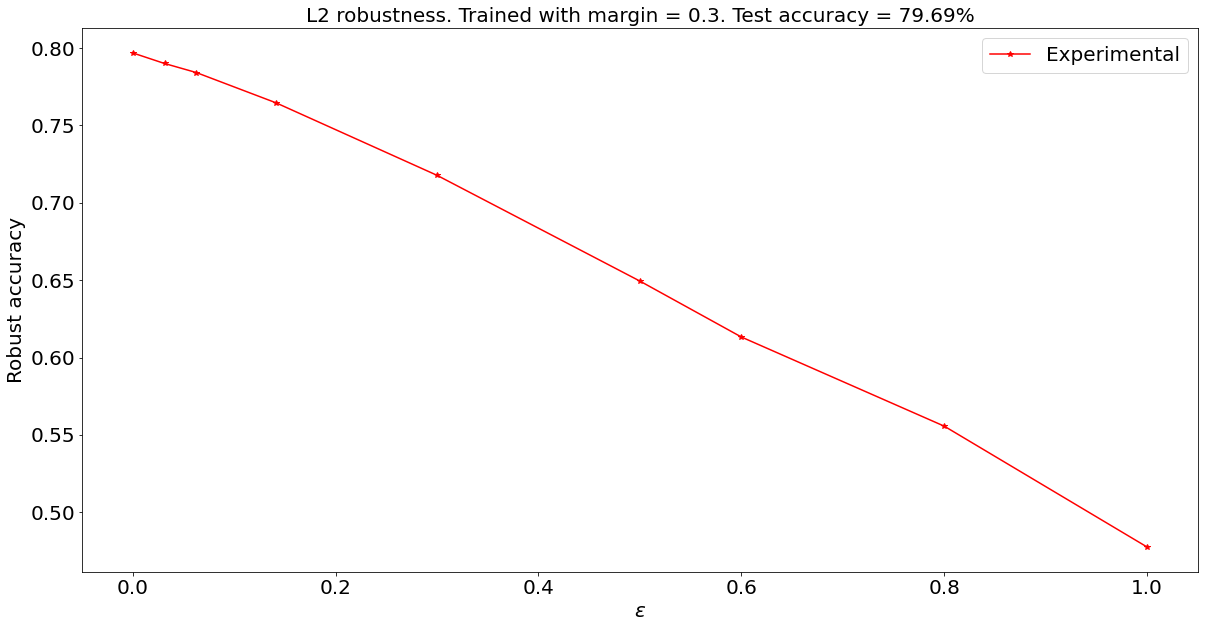

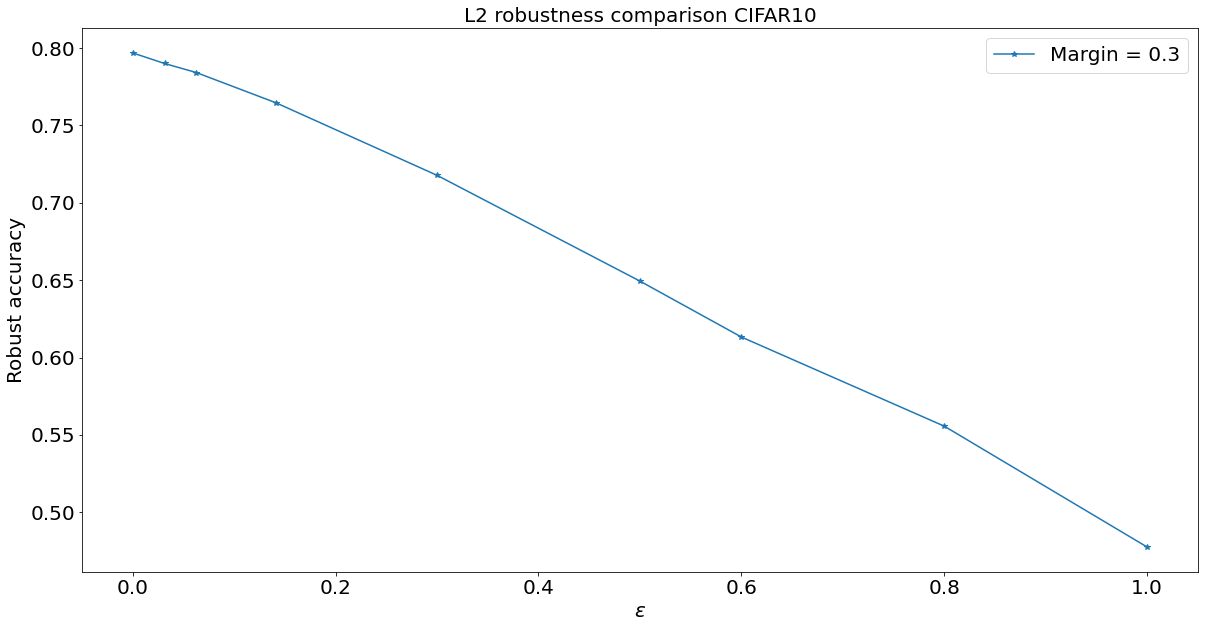

In [ ]:
#marginList = [0.05, 0.07, 0.1, 0.15,0.3, 0.5]
#marginList = [0.07, 0.15, 0.3]
marginList = [0.15]
#marginList = [0.07]
epsilons = [0.0, 8/255, 16/255, 36/255, 0.3, 0.5, 0.6, 0.8, 1.0]
saveRobAcc = np.zeros((len(marginList),len(epsilons)))
it = 0
for num,margin in enumerate(marginList):

  print(f"\n\n Now we are working with margin = {margin}\n\n")

  net = Network(3,32,64,128,4,4,4,S = 2, a = a, M=M)
  net.to(device);

  criterion = multiClassHingeLoss(margin = margin)
  #criterion = torch.nn.MultiMarginLoss(p=1, margin=margin)
  lr = 0.01
  
  optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)#,weight_decay=1e-4)
  #optimizer = optim.Adam(net.parameters(),lr=lr)#,weight_decay=1e-4)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
  
  model_save_name = f'CertifiedLip_margin_{margin}.pt'
  path = F"{model_save_name}" 

  if trainMode:
    loss = -1
    while loss<0:
      print(f"Training with learning rate {lr}")
      loss = train(net, margin, criterion, optimizer, scheduler, trainloader, testloader, device, epochs=100, reg=True, a=a, constrain = constrain)
      if loss<0:
        net = Network(3,32,64,128,4,4,4,S=2,a=a,M=M)
        net.to(device);
        lr/=10
        optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)#,weight_decay=1e-4)
        #optimizer = optim.Adam(net.parameters(),lr=lr)#,weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


    torch.save(net.state_dict(), path)
  else:
    net.load_state_dict(torch.load(path))
  
  model = nn.Sequential(Normalisation(),net).eval()
  fmodel = fb.PyTorchModel(model, bounds=(0, 1))

  acc = fb.utils.accuracy(fmodel, images, labels)

  attack = fb.attacks.L2PGD(steps=10)
  _, advs, success = attack(fmodel, images, labels, epsilons=epsilons)
  robust_accuracy = torch.mean((1-1.*success),axis=1)
  saveRobAcc[num] = robust_accuracy.detach().cpu().numpy()

  it += 1
  destination = f"updateMargin_{margin}.txt"
  np.savetxt(destination, saveRobAcc.reshape(-1,1))

  fig = plt.figure(figsize=(20,10))
  plt.plot(epsilons,robust_accuracy.detach().cpu().numpy(),'r-*',label="Experimental")
  plt.xlabel(r"$\varepsilon$",fontsize=20)
  plt.ylabel("Robust accuracy",fontsize=20)
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  plt.legend(fontsize=20,loc=1)
  plt.title(f"L2 robustness. Trained with margin = {margin}. Test accuracy = {round(acc * 100,2)}%",fontsize=20);

  plt.savefig(f'L2margin_{margin}.png')
  torch.save(net.state_dict(), f"trained_model_margin_{margin}.pt")
  
fig = plt.figure(figsize=(20,10))

for i in range(len(marginList)):
  plt.plot(epsilons,saveRobAcc[i],'-*',label=f"Margin = {marginList[i]}")

plt.xlabel(r"$\varepsilon$",fontsize=20)
plt.ylabel("Robust accuracy",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20,loc=1)
plt.title(f"L2 robustness comparison CIFAR10",fontsize=20);

plt.savefig(f'L2RobustnessComparison.png')